In [1]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright 2021-  QuOCS Team
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [2]:
import matplotlib.pyplot as plt
import os

# Ising model optimization

### The model

We take an Ising model Hamiltonian as our example problem, where *J* and *g* describe the nearest and next-nearest neighbor interaction of an Ising spin chain of *n* qubits. A global control field in the x-direction *u(t)* is used for the control of the system.

$H(t) = - J \sum_{j}^{n} \sigma_j^z \sigma_{j+1}^z \; - g \sum_{j}^{n} \sigma_j^z \sigma_{j+2}^z \; + u(t) \sum_{j}^{n} \sigma_j^x \;$

## dCRAB Optimization

### Define the Model

The user must write a class that is a child of the AbstractFoM class provided by QuOCS to define the problem to be solved. It must contain at least a function called get_FoM which takes the pulses, parameters and times as lists of numpy arrays (or floats for the parameters) and returns a dictionary with the figure of merit (FoM) under the key "FoM". What happens inside the get_FoM function is up to the user. 

In this code one can define *J* and *g* and the number of qubits, as well as the desired initial and target state after evolution of the Hamiltonian under the control field *u(t)*. In get_FoM the pulses are taken to caluclate the evolution under above Hamiltonian and the propagator is applied to the initial state. The resulting final state is overlapped with the target state to extract to state fidelity. This is passed back as a FoM.

In [3]:
import numpy as np
from quocslib.utils.AbstractFoM import AbstractFoM
from quocslib.timeevolution.piecewise_integrator import pw_evolution
import functools
from scipy.linalg import sqrtm


def tensor_together(A):
    """Takes a list of matrices and multiplies them together with the tensor product"""
    res = np.kron(A[0], A[1])
    if len(A) > 2:
        for two in A[2:]:
            res = np.kron(res, two)
    else:
        res = res
    return res


def get_static_hamiltonian(nqu, J, g):
    """
    Get the static Hamiltonian for the Ising model
    :param nqu: Number of qubits
    :param J: Nearest neighbour coupling
    :param g: Next-nearest neighbour coupling
    :return: The Hamiltonian
    """
    dim = 2**nqu
    H0 = np.zeros((dim, dim), dtype=np.complex128)
    i2 = np.eye(2)
    sz = np.array([[1, 0], [0, -1]], dtype="complex")
    for j in range(nqu):
        # set up holding array
        rest = [i2] * nqu
        # set the correct elements to sz
        # check, so we can implement a loop around
        if j == nqu - 1:
            idx1 = j
            idx2 = 0
        else:
            idx1 = j
            idx2 = j + 1
        rest[idx1] = sz
        rest[idx2] = sz
        H0 = H0 - J * tensor_together(rest)

    for j in range(nqu):
        # set up holding array
        rest = [i2] * nqu
        # set the correct elements to sz
        # check, so we can implement a loop around
        if j == nqu - 1:
            idx1 = j
            idx2 = 1
        elif j == nqu - 2:
            idx1 = j
            idx2 = 0
        else:
            idx1 = j
            idx2 = j + 2
        rest[idx1] = sz
        rest[idx2] = sz
        H0 = H0 - g * tensor_together(rest)
    return H0


def get_control_hamiltonian(nqu: int):
    """"
    Get the control Hamiltonian for the Ising model
    :param nqu: Number of qubits
    :return: The Hamiltonian
    """
    dim = 2**nqu
    H_at_t = np.zeros((dim, dim), dtype=np.complex128)
    i2 = np.eye(2)
    sx = np.array([[0, 1], [1, 0]], dtype="complex")
    for j in range(nqu):
        # set up holding array
        rest = [i2] * nqu
        # set the correct elements to sz
        # check, so we can implement a loop around
        rest[j] = sx
        H_at_t = H_at_t + tensor_together(rest)
    return H_at_t


def get_initial_state(nqu: int):
    """
    Get the initial state for the Ising model
    :param nqu:
    :return: Initial state density matrix
    """
    rho0 = np.array([[1, 0], [0, 0]], dtype=np.complex128)
    state = [rho0] * nqu
    return tensor_together(state)


def get_target_state(nqu: int):
    """
    Get the target state for the Ising model
    :param nqu:
    :return: Target state density matrix
    """
    rhoT = np.array([[0, 0], [0, 1]], dtype=np.complex128)
    state = [rhoT] * nqu
    return tensor_together(state)


def fidelity_funct(rho_evolved, rho_aim):
    """
    Function to calculate the overlap between two density matrices.
    :param rho_evolved:
    :param rho_aim:
    :return: overlap fidelity
    """
    return np.abs(np.trace(sqrtm(sqrtm(rho_evolved) @ rho_aim @ sqrtm(rho_evolved)))) ** 2


class IsingModel(AbstractFoM):
    """
    A figure of merit class for optimization of the problem defined by Alastair Marshall via
    https://arxiv.org/abs/2110.06187
    """
    def __init__(self, args_dict: dict = None):
        if args_dict is None:
            args_dict = {}

        ################################################################################################################
        # Dynamics variables
        ################################################################################################################
        self.n_qubits = args_dict.setdefault("n_qubits", 5)
        self.J = args_dict.setdefault("J", 1)
        self.g = args_dict.setdefault("g", 2)
        self.n_slices = args_dict.setdefault("n_slices", 100)

        self.is_maximization = args_dict.setdefault("is_maximization", False)
        self.FoM_factor = 1
        if self.is_maximization:
            self.FoM_factor = -1

        self.H_drift = get_static_hamiltonian(self.n_qubits, self.J, self.g)
        self.H_control = get_control_hamiltonian(self.n_qubits)
        self.rho_0 = get_initial_state(self.n_qubits)
        self.rho_target = get_target_state(self.n_qubits)
        self.rho_final = np.zeros_like(self.rho_target)
        # allocate memory for the list containing the propagators
        self.prop_store = [np.zeros_like(self.H_drift) for _ in range(self.n_slices)]
        # Check if the propagators are already computed
        self.propagators_are_computed = False

    def get_control_Hamiltonians(self):
        return self.H_control

    def get_drift_Hamiltonian(self):
        return self.H_drift

    def get_target_state(self):
        return self.rho_target

    def get_initial_state(self):
        return self.rho_0

    def get_propagator(self,
                       pulses_list: list = [],
                       time_grids_list: list = [],
                       parameters_list: list = []) -> np.array:
        """
        Compute and return the list of propagators
        :param pulses_list: List of pulses
        :param time_grids_list: List of time grids
        :param parameters_list: List of parameters
        :return: List of propagators"""
        drive = pulses_list[0].reshape(1, len(pulses_list[0]))
        n_slices = self.n_slices
        time_grid = time_grids_list[0]
        # dt = time_grid[1] - time_grid[0]
        dt = time_grid[-1] / len(time_grid)
        # Compute the time evolution
        self.prop_store = pw_evolution(self.prop_store, drive, self.H_drift, [self.H_control], n_slices, dt)
        self.propagators_are_computed = True
        return self.prop_store

    def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:
        """
        Compute and return the figure of merit
        :param pulses: List of pulses
        :param parameters: List of parameters
        :param timegrids: List of time grids
        :return dict: Figure of merit in a dictionary
        """
        # Check if the propagator list is computed before compute the final propagator
        if not self.propagators_are_computed:
            self.get_propagator(pulses_list=pulses, time_grids_list=timegrids, parameters_list=parameters)
        self.propagators_are_computed = False
        # Compute the final propagator
        U_final = functools.reduce(lambda a, b: a @ b, self.prop_store)
        # evolve initial state
        rho_final = U_final @ self.rho_0 @ U_final.T.conj()
        # Calculate the fidelity
        fidelity = -1 * self.FoM_factor * fidelity_funct(rho_final.T, self.rho_target)
        return {"FoM": fidelity}


### Define the configuration dictionary
This dictionary is passed to the QuOCS optimized in order to tell it what optimization algorithm to use. I also contains further settings for the optimization process.

First, we give the optimization a name, which will also appear in the name of the results folder generated.

In [4]:
optimization_dictionary = {"optimization_client_name": "IsingModeldCRAB"}

#### Settings for the optimization algorithm
The "algotithm_settings" key in gets a dictionary with the name of the algorithm. In this case we use the dCRAB algorithm.

In [5]:
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}

Now we define some settings for dCRAB: Since we want to maximize the state overlap with the target state, we set the optimization direction to "maximization". The maximal number of super-iterations and the maximal total number of FoM function evaluations.

In [6]:
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "maximization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 3 
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 2000

#### Settings for the direct search
Next, let's define the settings for the direct search method (dsm) used to find the basis coefficients during each superiteration (SI) of the dCRAB method. We want to use a Nelder-Mead search and stop each SI if the variance in the parameters of the search space or the FoM values of the simplex are below a certain threshold. Also, we want to continus with the next SI if the FoM does not change more than 0.01 over 200 function evaluations.

In [7]:
dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 200,
                "cbs_change": 0.01
            }
        }
    }

And add this information as "dsm_settings" to the "algorithm_settings" of the optimization_dictionary.

In [8]:
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings

#### The Controls
The controls are given by a pulse in x-direction. Let's give it some limits, a discretization (100 bins) and an initial variation of the pulse amplitudes depending on the basis in which we expand the pulse. If the Fourier basis is used, this corresponds directly to the amplitudes of the sin-functions with which the pulse is varied. Note that, in general, small values correspond to local searches and lage values result in global searches. The amplitude variation should be given in the same units as the function values. Typically ~30\% of the maximal possible amplitude is a useful starting value. We also connect a time object named "time_1" (defined later) to the pulse to tell it about the duration of the pulse.

In [9]:
pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 100.0,
           "lower_limit": -100.0,
           "bins_number": 100,
           "amplitude_variation": 30.0,
           "time_name": "time_1"
           }

#### The initial guess
An initial guess can be provided. We use the definition via a Python lambda function to tell QuOCS to start from a pulse which is zero at any time. In this specific case the guess can be omitted, since the default is the same. However, we add this here as an example.

In [10]:
pulse_x["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 0.0 + 0.0*t"
    }

### The basis
The "basis" option describes the basis in which to expand the control pulses for the dCRAB search. We use the Fourier basis and update the pulse with 5 sine/cosine waves of randomly selected frequency uniformly chosen from the interval of 0.01 to 10 oscillations over the duration of the pulse.

In [11]:
pulse_x["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 5,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 10.0
                }
            }

#### The times
If there are several pulses on different timescales, you can define different times here and link them to the pulses accordingly. In our case we have the aforementioned "time_1" which we set to 1.

In [12]:
time1 = {"time_name": "time_1",
         "initial_value": 1.0 }

Now, let's insert the controls in the optimization_dictionary

In [13]:
optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]

### Create the optimizer and run the optimization
All you need to do now is to import the Optimizer from QuOCS and create an optimization object by passing an instance of the FoM object (here IsingModel()) and the optimization_dictionary.

In [14]:
from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, IsingModel({"is_maximization": True}))

INFO     oc_logger    The optimization direction is maximization


To run the optimization, call the .execute() function on the optimization object.

In [15]:
time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    QuOCS version number: 0.0.55
INFO     oc_logger    Direct search start time has been reset.
INFO     oc_logger    New record achieved. Previous FoM: -10000000000, new best FoM : 0.0
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.0
INFO     oc_logger    New record achieved. Previous FoM: 0.0, new best FoM : 0.3129247062963575
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.3129247062963575
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.19720116369502222
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.20714278236069417
INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.040812283490119186
INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.09188858346404977
INFO     oc_logger    Function evaluation number: 7, SI:

INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 29, FoM: 0.787926984331643
INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 29, FoM: 0.2768233092096261
INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 30, FoM: 0.47039204091292397
INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 31, FoM: 0.6835664618456775
INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 32, FoM: 0.5538112360797554
INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 33, FoM: 0.625355340579099
INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 34, FoM: 0.36227072181556635
INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 34, FoM: 0.7361002539166451
INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 35, FoM: 0.5029796585953551
I

INFO     oc_logger    Function evaluation number: 135, SI: 1, Sub-iteration number: 71, FoM: 0.8893477727193063
INFO     oc_logger    Function evaluation number: 136, SI: 1, Sub-iteration number: 71, FoM: 0.9133759285515053
INFO     oc_logger    Function evaluation number: 137, SI: 1, Sub-iteration number: 72, FoM: 0.9162805814701207
INFO     oc_logger    Function evaluation number: 138, SI: 1, Sub-iteration number: 73, FoM: 0.9078561171787823
INFO     oc_logger    Function evaluation number: 139, SI: 1, Sub-iteration number: 74, FoM: 0.9223850626382121
INFO     oc_logger    Function evaluation number: 140, SI: 1, Sub-iteration number: 75, FoM: 0.909887691663665
INFO     oc_logger    Function evaluation number: 141, SI: 1, Sub-iteration number: 76, FoM: 0.9106801396423668
INFO     oc_logger    New record achieved. Previous FoM: 0.9233090038054032, new best FoM : 0.9247213467134285
INFO     oc_logger    Function evaluation number: 142, SI: 1, Sub-iteration number: 77, FoM: 0.92472134671

INFO     oc_logger    Function evaluation number: 201, SI: 1, Sub-iteration number: 116, FoM: 0.9489614226507624
INFO     oc_logger    Function evaluation number: 202, SI: 1, Sub-iteration number: 117, FoM: 0.9487805114731609
INFO     oc_logger    Function evaluation number: 203, SI: 1, Sub-iteration number: 118, FoM: 0.9516018510367532
INFO     oc_logger    Function evaluation number: 204, SI: 1, Sub-iteration number: 119, FoM: 0.949491711584657
INFO     oc_logger    Function evaluation number: 205, SI: 1, Sub-iteration number: 120, FoM: 0.9502048782509448
INFO     oc_logger    Function evaluation number: 206, SI: 1, Sub-iteration number: 121, FoM: 0.9461481824386331
INFO     oc_logger    Function evaluation number: 207, SI: 1, Sub-iteration number: 121, FoM: 0.9507322020677899
INFO     oc_logger    Function evaluation number: 208, SI: 1, Sub-iteration number: 122, FoM: 0.9406477454162527
INFO     oc_logger    Function evaluation number: 209, SI: 1, Sub-iteration number: 122, FoM: 0.9

INFO     oc_logger    New record achieved. Previous FoM: 0.9529626559955157, new best FoM : 0.9530703873863271
INFO     oc_logger    Function evaluation number: 267, SI: 1, Sub-iteration number: 158, FoM: 0.9530703873863271
INFO     oc_logger    Function evaluation number: 268, SI: 1, Sub-iteration number: 158, FoM: 0.9526307037491631
INFO     oc_logger    Function evaluation number: 269, SI: 1, Sub-iteration number: 159, FoM: 0.9529495838172286
INFO     oc_logger    Function evaluation number: 270, SI: 1, Sub-iteration number: 160, FoM: 0.9525475944794937
INFO     oc_logger    New record achieved. Previous FoM: 0.9530703873863271, new best FoM : 0.9530884566953255
INFO     oc_logger    Function evaluation number: 271, SI: 1, Sub-iteration number: 160, FoM: 0.9530884566953255
INFO     oc_logger    Function evaluation number: 272, SI: 1, Sub-iteration number: 161, FoM: 0.9528540922426968
INFO     oc_logger    Function evaluation number: 273, SI: 1, Sub-iteration number: 161, FoM: 0.9530

INFO     oc_logger    Function evaluation number: 334, SI: 1, Sub-iteration number: 186, FoM: 0.953042010229456
INFO     oc_logger    Function evaluation number: 335, SI: 1, Sub-iteration number: 186, FoM: 0.9531556346071053
INFO     oc_logger    Function evaluation number: 336, SI: 1, Sub-iteration number: 186, FoM: 0.9531444392402074
INFO     oc_logger    Function evaluation number: 337, SI: 1, Sub-iteration number: 186, FoM: 0.9531330798465194
INFO     oc_logger    Function evaluation number: 338, SI: 1, Sub-iteration number: 186, FoM: 0.9531221703115222
INFO     oc_logger    Function evaluation number: 339, SI: 1, Sub-iteration number: 186, FoM: 0.9531239222043841
INFO     oc_logger    Function evaluation number: 340, SI: 1, Sub-iteration number: 187, FoM: 0.9530556530664165
INFO     oc_logger    Function evaluation number: 341, SI: 1, Sub-iteration number: 187, FoM: 0.9530683688056808
INFO     oc_logger    Function evaluation number: 342, SI: 1, Sub-iteration number: 188, FoM: 0.9

INFO     oc_logger    Function evaluation number: 405, SI: 2, Sub-iteration number: 7, FoM: 0.30990839031145295
INFO     oc_logger    Function evaluation number: 406, SI: 2, Sub-iteration number: 8, FoM: 0.15549377957324528
INFO     oc_logger    Function evaluation number: 407, SI: 2, Sub-iteration number: 8, FoM: 0.14342627918656223
INFO     oc_logger    Function evaluation number: 408, SI: 2, Sub-iteration number: 8, FoM: 0.9203576038990623
INFO     oc_logger    Function evaluation number: 409, SI: 2, Sub-iteration number: 8, FoM: 0.42522582755233707
INFO     oc_logger    Function evaluation number: 410, SI: 2, Sub-iteration number: 8, FoM: 0.7643139231862207
INFO     oc_logger    Function evaluation number: 411, SI: 2, Sub-iteration number: 8, FoM: 0.17024952746557614
INFO     oc_logger    Function evaluation number: 412, SI: 2, Sub-iteration number: 8, FoM: 0.8262045419451894
INFO     oc_logger    Function evaluation number: 413, SI: 2, Sub-iteration number: 8, FoM: 0.5881312824524

INFO     oc_logger    Function evaluation number: 479, SI: 2, Sub-iteration number: 38, FoM: 0.9503251912338656
INFO     oc_logger    Function evaluation number: 480, SI: 2, Sub-iteration number: 39, FoM: 0.9323871345972281
INFO     oc_logger    Function evaluation number: 481, SI: 2, Sub-iteration number: 39, FoM: 0.9521144705160273
INFO     oc_logger    Function evaluation number: 482, SI: 2, Sub-iteration number: 40, FoM: 0.9176432451240482
INFO     oc_logger    Function evaluation number: 483, SI: 2, Sub-iteration number: 40, FoM: 0.9515911538024954
INFO     oc_logger    Function evaluation number: 484, SI: 2, Sub-iteration number: 41, FoM: 0.9368597428906311
INFO     oc_logger    Function evaluation number: 485, SI: 2, Sub-iteration number: 41, FoM: 0.9528914476366439
INFO     oc_logger    Function evaluation number: 486, SI: 2, Sub-iteration number: 42, FoM: 0.951623490981528
INFO     oc_logger    Function evaluation number: 487, SI: 2, Sub-iteration number: 43, FoM: 0.9425635917

INFO     oc_logger    Function evaluation number: 544, SI: 2, Sub-iteration number: 82, FoM: 0.9659201720643684
INFO     oc_logger    Function evaluation number: 545, SI: 2, Sub-iteration number: 83, FoM: 0.9629259398880176
INFO     oc_logger    Function evaluation number: 546, SI: 2, Sub-iteration number: 83, FoM: 0.965935741539255
INFO     oc_logger    Function evaluation number: 547, SI: 2, Sub-iteration number: 84, FoM: 0.964972175243055
INFO     oc_logger    Function evaluation number: 548, SI: 2, Sub-iteration number: 85, FoM: 0.9677026600374983
INFO     oc_logger    Function evaluation number: 549, SI: 2, Sub-iteration number: 86, FoM: 0.9666767586472046
INFO     oc_logger    Function evaluation number: 550, SI: 2, Sub-iteration number: 87, FoM: 0.9672723366212307
INFO     oc_logger    Function evaluation number: 551, SI: 2, Sub-iteration number: 88, FoM: 0.9661895377955522
INFO     oc_logger    Function evaluation number: 552, SI: 2, Sub-iteration number: 89, FoM: 0.96749253744

INFO     oc_logger    Function evaluation number: 610, SI: 2, Sub-iteration number: 129, FoM: 0.9717479118401643
INFO     oc_logger    Function evaluation number: 611, SI: 2, Sub-iteration number: 130, FoM: 0.9711158139404031
INFO     oc_logger    Function evaluation number: 612, SI: 2, Sub-iteration number: 130, FoM: 0.9720277899692327
INFO     oc_logger    Function evaluation number: 613, SI: 2, Sub-iteration number: 131, FoM: 0.9718335395529917
INFO     oc_logger    Function evaluation number: 614, SI: 2, Sub-iteration number: 132, FoM: 0.971627218713629
INFO     oc_logger    Function evaluation number: 615, SI: 2, Sub-iteration number: 132, FoM: 0.9720645222321675
INFO     oc_logger    Function evaluation number: 616, SI: 2, Sub-iteration number: 133, FoM: 0.9715972360974059
INFO     oc_logger    Function evaluation number: 617, SI: 2, Sub-iteration number: 133, FoM: 0.9719691813741506
INFO     oc_logger    New record achieved. Previous FoM: 0.9720954842283931, new best FoM : 0.972

INFO     oc_logger    Function evaluation number: 672, SI: 2, Sub-iteration number: 175, FoM: 0.9729646665861642
INFO     oc_logger    Function evaluation number: 673, SI: 2, Sub-iteration number: 176, FoM: 0.9730144310728508
INFO     oc_logger    New record achieved. Previous FoM: 0.9732001926277153, new best FoM : 0.9733091674438977
INFO     oc_logger    Function evaluation number: 674, SI: 2, Sub-iteration number: 177, FoM: 0.9733091674438977
INFO     oc_logger    Function evaluation number: 675, SI: 2, Sub-iteration number: 177, FoM: 0.9732208635831797
INFO     oc_logger    New record achieved. Previous FoM: 0.9733091674438977, new best FoM : 0.973411211060563
INFO     oc_logger    Function evaluation number: 676, SI: 2, Sub-iteration number: 178, FoM: 0.973411211060563
INFO     oc_logger    New record achieved. Previous FoM: 0.973411211060563, new best FoM : 0.9736435538919993
INFO     oc_logger    Function evaluation number: 677, SI: 2, Sub-iteration number: 178, FoM: 0.973643553

INFO     oc_logger    Function evaluation number: 734, SI: 3, Sub-iteration number: 2, FoM: 0.14257004429541603
INFO     oc_logger    Function evaluation number: 735, SI: 3, Sub-iteration number: 2, FoM: 0.31088989975592907
INFO     oc_logger    Function evaluation number: 736, SI: 3, Sub-iteration number: 2, FoM: 0.07033367817925709
INFO     oc_logger    Function evaluation number: 737, SI: 3, Sub-iteration number: 2, FoM: 0.08272541511659796
INFO     oc_logger    Function evaluation number: 738, SI: 3, Sub-iteration number: 2, FoM: 0.030385407265129817
INFO     oc_logger    Function evaluation number: 739, SI: 3, Sub-iteration number: 2, FoM: 0.1921675530910235
INFO     oc_logger    Function evaluation number: 740, SI: 3, Sub-iteration number: 2, FoM: 0.13655104180325808
INFO     oc_logger    Function evaluation number: 741, SI: 3, Sub-iteration number: 2, FoM: 0.00597217225852648
INFO     oc_logger    Function evaluation number: 742, SI: 3, Sub-iteration number: 2, FoM: 0.2756672514

INFO     oc_logger    Function evaluation number: 808, SI: 3, Sub-iteration number: 28, FoM: 0.9181079081095627
INFO     oc_logger    Function evaluation number: 809, SI: 3, Sub-iteration number: 29, FoM: 0.8741199092163128
INFO     oc_logger    Function evaluation number: 810, SI: 3, Sub-iteration number: 29, FoM: 0.964939799492876
INFO     oc_logger    Function evaluation number: 811, SI: 3, Sub-iteration number: 30, FoM: 0.9091821875537852
INFO     oc_logger    Function evaluation number: 812, SI: 3, Sub-iteration number: 30, FoM: 0.9647667678834879
INFO     oc_logger    Function evaluation number: 813, SI: 3, Sub-iteration number: 31, FoM: 0.8952563272930071
INFO     oc_logger    Function evaluation number: 814, SI: 3, Sub-iteration number: 31, FoM: 0.9682619521972724
INFO     oc_logger    Function evaluation number: 815, SI: 3, Sub-iteration number: 32, FoM: 0.9379767087518188
INFO     oc_logger    Function evaluation number: 816, SI: 3, Sub-iteration number: 33, FoM: 0.9230905427

INFO     oc_logger    Function evaluation number: 877, SI: 3, Sub-iteration number: 69, FoM: 0.9783916996719353
INFO     oc_logger    Function evaluation number: 878, SI: 3, Sub-iteration number: 70, FoM: 0.9782602038731216
INFO     oc_logger    Function evaluation number: 879, SI: 3, Sub-iteration number: 71, FoM: 0.9781945006965288
INFO     oc_logger    Function evaluation number: 880, SI: 3, Sub-iteration number: 72, FoM: 0.9767043320141156
INFO     oc_logger    Function evaluation number: 881, SI: 3, Sub-iteration number: 72, FoM: 0.9785006499272867
INFO     oc_logger    New record achieved. Previous FoM: 0.9790469404497233, new best FoM : 0.9793432485845786
INFO     oc_logger    Function evaluation number: 882, SI: 3, Sub-iteration number: 73, FoM: 0.9793432485845786
INFO     oc_logger    Function evaluation number: 883, SI: 3, Sub-iteration number: 73, FoM: 0.9792880823729809
INFO     oc_logger    Function evaluation number: 884, SI: 3, Sub-iteration number: 74, FoM: 0.9793252727

INFO     oc_logger    Function evaluation number: 939, SI: 3, Sub-iteration number: 112, FoM: 0.980484189681198
INFO     oc_logger    Function evaluation number: 940, SI: 3, Sub-iteration number: 113, FoM: 0.9803443148107506
INFO     oc_logger    Function evaluation number: 941, SI: 3, Sub-iteration number: 113, FoM: 0.9805454569552976
INFO     oc_logger    Function evaluation number: 942, SI: 3, Sub-iteration number: 114, FoM: 0.9804051384037392
INFO     oc_logger    Function evaluation number: 943, SI: 3, Sub-iteration number: 114, FoM: 0.9806195570611675
INFO     oc_logger    Function evaluation number: 944, SI: 3, Sub-iteration number: 115, FoM: 0.9801766539961317
INFO     oc_logger    Function evaluation number: 945, SI: 3, Sub-iteration number: 115, FoM: 0.9806020957958886
INFO     oc_logger    Function evaluation number: 946, SI: 3, Sub-iteration number: 116, FoM: 0.9807155092493719
INFO     oc_logger    Function evaluation number: 947, SI: 3, Sub-iteration number: 117, FoM: 0.9

INFO     oc_logger    New record achieved. Previous FoM: 0.9815621254202306, new best FoM : 0.9815824513182223
INFO     oc_logger    Function evaluation number: 1002, SI: 3, Sub-iteration number: 161, FoM: 0.9815824513182223
INFO     oc_logger    Function evaluation number: 1003, SI: 3, Sub-iteration number: 161, FoM: 0.981399159462947
INFO     oc_logger    New record achieved. Previous FoM: 0.9815824513182223, new best FoM : 0.9816829629196283
INFO     oc_logger    Function evaluation number: 1004, SI: 3, Sub-iteration number: 162, FoM: 0.9816829629196283
INFO     oc_logger    New record achieved. Previous FoM: 0.9816829629196283, new best FoM : 0.9817580553648956
INFO     oc_logger    Function evaluation number: 1005, SI: 3, Sub-iteration number: 162, FoM: 0.9817580553648956
INFO     oc_logger    Function evaluation number: 1006, SI: 3, Sub-iteration number: 163, FoM: 0.9814031564390475
INFO     oc_logger    Function evaluation number: 1007, SI: 3, Sub-iteration number: 164, FoM: 0.9

#### Results
Let us visualize the optimization by looking at the evolution of the FoM over the function evaluations and the final control pulse.

Text(0, 0.5, 'Amplitude')

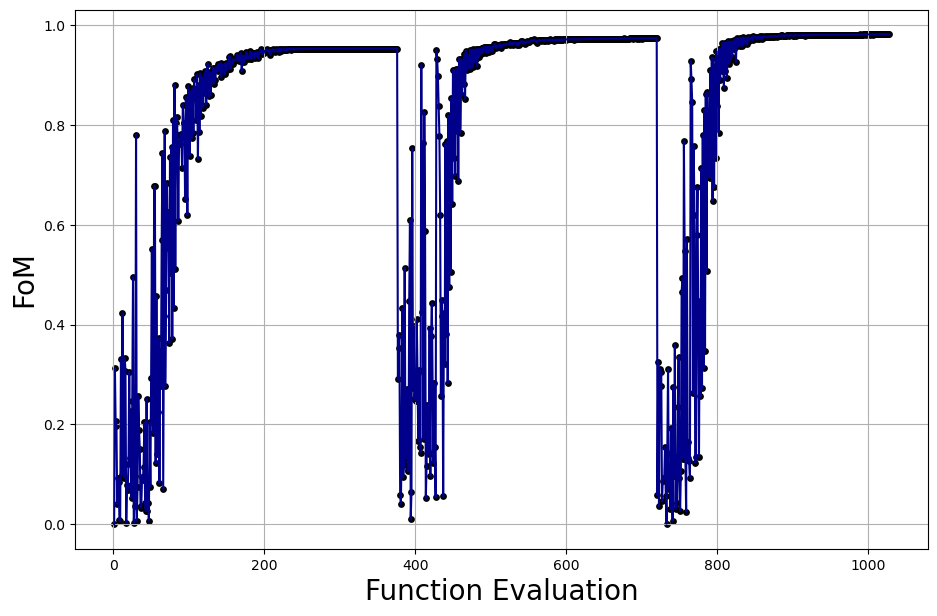

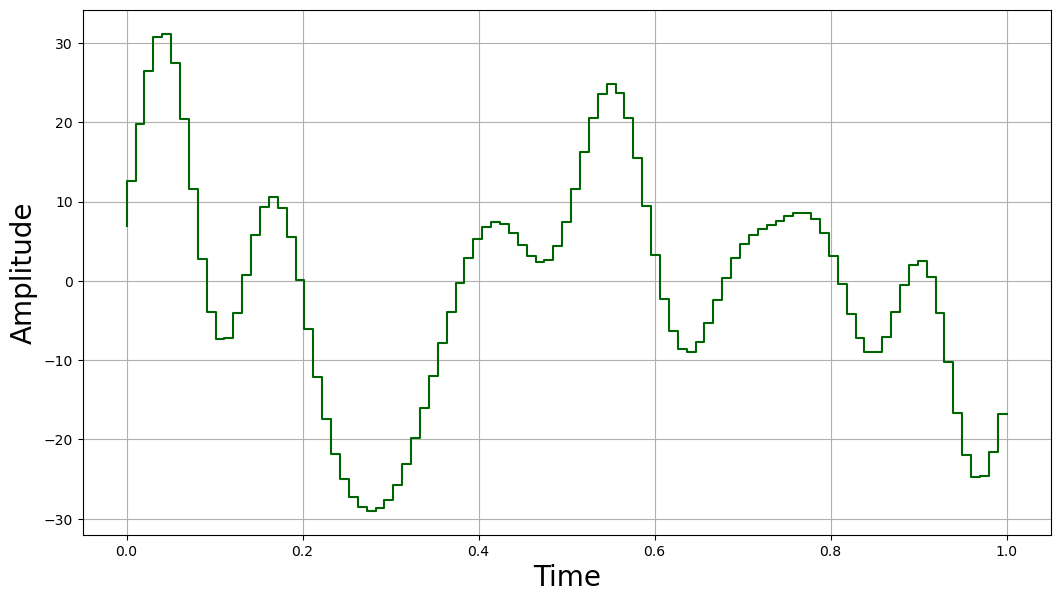

In [16]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)